In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_palette("pastel")
from multiprocessing import Pool
from tqdm import tqdm
import statsmodels.api as sm
from datetime import datetime,time,timedelta
import mplfinance as mpf
from functools import partial

In [ ]:
def time_parse(time_code):
    if time_code == 0:
        return np.nan
    time_code = str(time_code)
    hour = int(time_code[-12:-10])
    minute = int(time_code[-10:-8])
    second = int(time_code[-8:-6])
    dt_object = time(hour, minute, second)
    return dt_object

In [268]:
DATE = '20240626'

In [303]:
samples = []
for DATE in ['20240626','20240627','20240628']:
    market_data = pd.read_table('/mydata2/wangs/data/L2/equity_price'+DATE+'.txt')

    deal_list = pd.read_excel(DATE+'.xlsx',index_col = 0)
    deal_list['成交时间截面'] = deal_list['成交时间'].apply(time_parse)
    
    deal_list = deal_list[~deal_list['code'].isin([600361,2869,600692,600939])]
    deal_list.index = range(deal_list.shape[0])
    
    unfinished = []
    data_all = pd.DataFrame(columns=['code','成交日期','成交时间','截面时间_d','bidprice_d','bidvolume_d','askprice_d','askvolume_d','截面时间_u','bidprice_u','bidvolume_u','askprice_u','askvolume_u'])
    for i in range(len(deal_list)):
        code = deal_list['code'][i]
        # print(code)
        if pd.isna(deal_list['成交时间截面'][i]) == True:
            unfinished.append(code)
        else:
            dt_object = deal_list['成交时间截面'][i]
            current_date = datetime.now().date()
            dt_object = datetime.combine(current_date, dt_object)
            time_stamp = market_data[market_data['ticker'] == code]['datatime']
            down_time,up_time = time_stamp[(time_stamp <= str((dt_object + timedelta(seconds=3)).time())) * (time_stamp >= str((dt_object - timedelta(seconds=3)).time()))].values[:2]
            temdata1 = market_data[market_data['ticker'] == code][time_stamp == down_time]
            temdata2 = market_data[market_data['ticker'] == code][time_stamp == up_time]
            data_all.loc[len(data_all)] = [code,temdata1['datadate'].values[0],dt_object.time(),down_time,temdata1['bidprice1'].values[0],temdata1['bidvolume1'].values[0],temdata1['askprice1'].values[0],temdata1['askvolume1'].values[0],up_time,temdata2['bidprice1'].values[0],temdata2['bidvolume1'].values[0],temdata2['askprice1'].values[0],temdata2['askvolume1'].values[0]]
    
    # 1. 成交前一tick 卖一价为0；后一tick  卖一价不为0。判断为“炸板成交”
    # 2. 成交前一tick 卖一价为0，买一委托金额为M0；后一tick  卖一价为0，买一委托金额为M1，且-500w < M1 - M0 ；判断为“排板成交”
    # 2. 成交前一tick 卖一价为0，买一委托金额为M0；后一tick  卖一价为0，买一委托金额为M1，且M1 - M0< -500w；判断为“砸板成交”
    # 3. 成交前一tick 卖一价不为0；后一tick  卖一价为0，买一委托金额为M1，且M1>500w；判断为“抢板成交”
    # 4. 成交前一tick 卖一价不为0；后一tick  卖一价不为0；判断为“抢跑成交”
    
    type_1 = (data_all['askprice_d'] == 0) * (data_all['askprice_u'] != 0) * 1
    type_2 = (data_all['askprice_d'] == 0) * (data_all['askprice_u'] == 0) * ((data_all['bidvolume_u'] * data_all['bidprice_u'] - data_all['bidvolume_d']* data_all['bidprice_d']) > -5000000) * 2
    type_3 = (data_all['askprice_d'] == 0) * (data_all['askprice_u'] == 0) * ((data_all['bidvolume_u'] * data_all['bidprice_u'] - data_all['bidvolume_d']* data_all['bidprice_d']) < -5000000) * 3
    type_4 = (data_all['askprice_d'] != 0) * (data_all['askprice_u'] == 0) * (data_all['bidvolume_u'] * data_all['bidprice_u'] > 5000000) * 4
    type_5 = (data_all['askprice_d'] != 0) * (data_all['askprice_u'] != 0) * 5
    status = type_1 + type_2 + type_3 + type_4 + type_5
    data_all['status'] = status
    data_all['status'] = data_all['status'].replace({1:'炸板成交',2:'排板成交',3:'砸板成交',4:'抢板成交',5:'抢跑成交'})
    data_all = data_all.set_index('code')
    
    def trans_code(code):
        code = str(code)
        length = len(code)
        fill = 6-length
        if fill > 0:
            for i in range(fill):
                code = '0'+code
        if code[0] == '6':
            return code + '.SH'
        else:
            return code + '.SZ'
    stock_list = list(data_all.index.map(trans_code).values)
    data_all['是否涨停'] = (ff.read('up').loc[stock_list,DATE]).replace({np.nan:0}).values
    # data_all['code'] = stock_list
    
    sample = data_all[['成交时间','status','是否涨停']]
    
    sample = pd.concat([deal_list.set_index('code'),sample],axis = 1)
    sample.index = sample.index.map(lambda x:str(x).zfill(6))
    sample['market'] = sample.index.map(lambda x:'SH' if x[0]=='6' else 'SZ')
    
    sample['status'] = sample['status'].fillna('未成交')
    sample['status'] = sample['status'].map(lambda x:'抢板成交' if x==0 else x)
    samples.append(sample)

In [318]:
samples[2].shape

(34, 15)

In [315]:
sample.shape

(88, 15)

In [319]:
sample = pd.concat(samples,axis = 0)

In [320]:
sample.groupby(sample['status'])[['计算时间','指令等待时间','指令-交易所时间','成交等待耗时','整体延时']].median().sort_values('整体延时')

,计算时间,指令等待时间,指令-交易所时间,成交等待耗时,整体延时
status,,,,,
抢板成交,2.1001,0.1282,0.3547,0.0425,2.5079
未成交,2.5093,0.1655,0.4232,NaN,3.1393
抢跑成交,11.0572,0.1282,4.0429,0.0454,16.1551
排板成交,13.9492,0.1309,4.6906,37807.4992,19.0802
砸板成交,19.3995,0.1838,5.3310,7852.7117,25.5822
炸板成交,22.4402,0.3872,4.9054,2479.1723,28.0093


In [321]:
sh = sample[sample['market']=='SH']
sh_res = sh.groupby(sh['status'])[['计算时间','指令等待时间','指令-交易所时间','成交等待耗时','整体延时']].median().sort_values('整体延时')
sh_res['数量'] = sh.groupby(sh['status'])['market'].count()
sh_res['收盘是否封住'] = sh.groupby(sh['status'])['是否涨停'].mean()

In [322]:
sh_res.applymap(lambda x: '%.4f' % x if isinstance(x, float) else x)#.sort_values('整体延时')

,计算时间,指令等待时间,指令-交易所时间,成交等待耗时,整体延时,数量,收盘是否封住
status,,,,,,,
排板成交,18.4601,0.1733,5.0715,26160.5638,23.6549,8,0.6250
抢跑成交,19.5888,0.2751,4.6974,0.0468,24.4388,17,0.5882
砸板成交,22.1842,0.2865,5.6790,8732.4021,27.5087,10,0.3000
抢板成交,23.2551,0.2772,5.2613,0.0581,28.8724,3,1.0000
炸板成交,23.8300,0.5254,5.0313,4591.8408,29.3867,2,0.0000
未成交,24.9591,0.3222,4.8778,nan,30.6279,6,nan


In [323]:
sz = sample[sample['market']=='SZ']
sz_res = sz.groupby(sz['status'])[['计算时间','指令等待时间','指令-交易所时间','成交等待耗时','整体延时']].median().sort_values('整体延时')
sz_res['数量'] = sz.groupby(sz['status'])['market'].count()
sz_res['收盘是否封住'] = sz.groupby(sz['status'])['是否涨停'].mean()
sz_res

,计算时间,指令等待时间,指令-交易所时间,成交等待耗时,整体延时,数量,收盘是否封住
status,,,,,,,
砸板成交,1.41860,0.09890,0.32070,5932.22200,1.75890,3,0.666667
抢跑成交,1.60345,0.09010,0.28635,0.04260,2.13455,14,0.571429
排板成交,1.81780,0.07570,0.27600,64257.88290,2.15700,5,0.600000
未成交,1.66390,0.10840,0.27130,NaN,2.24440,11,NaN
抢板成交,1.79755,0.08705,0.33310,0.03385,2.47880,8,0.500000
炸板成交,2.99100,0.15900,0.27620,781.42110,3.42620,1,1.000000


In [324]:
sh_counts = sample[sample['market']=='SH']['status'].value_counts()
sz_counts = sample[sample['market']=='SZ']['status'].value_counts()

In [325]:
pd.DataFrame([sh_counts/sh_counts.sum(),sz_counts/sz_counts.sum()],index = ['上海','深圳']).T.fillna(0)

,上海,深圳
抢跑成交,0.369565,0.333333
砸板成交,0.217391,0.071429
排板成交,0.173913,0.119048
未成交,0.130435,0.261905
抢板成交,0.065217,0.190476
炸板成交,0.043478,0.023810


<BarContainer object of 5 artists>

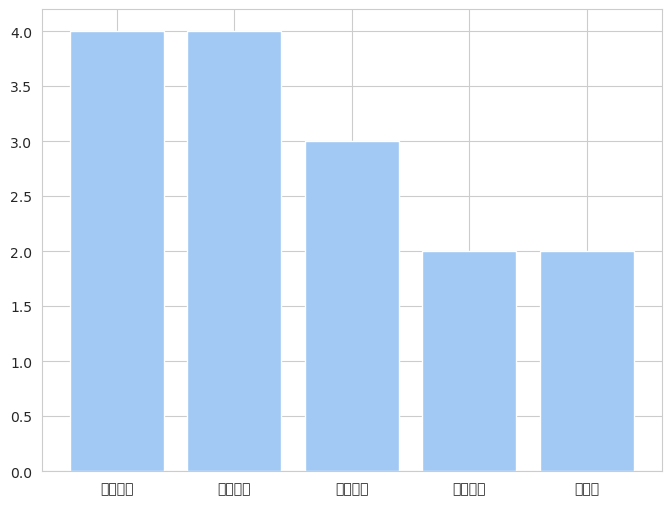

In [301]:
plt.figure(figsize=(8, 6))  # Set the figure size
plt.bar(sh_counts.index,sh_counts.values)
